In [1]:
from pyspark.sql import SparkSession
from typing import List
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Question 1
Given a clickstream of user activity data, find the relevant user session for each click event.

Session definition:

Session expires after inactivity of 30mins, because of inactivity no clickstream will be generated

Session remains active for a total of 2 hours


In [2]:
spark = SparkSession.builder \
    .appName("ClickStreamSession") \
    .getOrCreate()

schema = "click_time STRING, user_id STRING"

data = [
    ("2018-01-01 11:00:00", "u1"),
    ("2018-01-01 12:00:00", "u1"),
    ("2018-01-01 13:00:00", "u1"),
    ("2018-01-01 13:00:00", "u1"),
    ("2018-01-01 14:00:00", "u1"),
    ("2018-01-01 15:00:00", "u1"),
    ("2018-01-01 11:00:00", "u2"),
    ("2018-01-02 11:00:00", "u2")
]

clickstream_df = spark.createDataFrame(data, schema=schema)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/04 14:14:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/04 14:14:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
clickstream_df = clickstream_df.withColumn("click_time", F.to_timestamp("click_time"))

In [4]:
clickstream_df.show()   

+-------------------+-------+
|         click_time|user_id|
+-------------------+-------+
|2018-01-01 11:00:00|     u1|
|2018-01-01 12:00:00|     u1|
|2018-01-01 13:00:00|     u1|
|2018-01-01 13:00:00|     u1|
|2018-01-01 14:00:00|     u1|
|2018-01-01 15:00:00|     u1|
|2018-01-01 11:00:00|     u2|
|2018-01-02 11:00:00|     u2|
+-------------------+-------+



In [5]:
window_spec = Window.partitionBy("user_id").orderBy("click_time")

In [14]:
clickstream_df = clickstream_df.withColumn("time_diff", (F.unix_timestamp("click_time")  - F.unix_timestamp(F.lag("click_time").over(window_spec))) / 3600)

In [16]:
clickstream_df = clickstream_df.withColumn("session_id", F.sum(F.when(F.col("time_diff") > 0.5, 1).otherwise(0)).over(window_spec))

In [17]:
clickstream_df.show()

+-------------------+-------+---------+----------+
|         click_time|user_id|time_diff|session_id|
+-------------------+-------+---------+----------+
|2018-01-01 11:00:00|     u1|     NULL|         0|
|2018-01-01 12:00:00|     u1|      1.0|         1|
|2018-01-01 13:00:00|     u1|      1.0|         2|
|2018-01-01 13:00:00|     u1|      0.0|         2|
|2018-01-01 14:00:00|     u1|      1.0|         3|
|2018-01-01 15:00:00|     u1|      1.0|         4|
|2018-01-01 11:00:00|     u2|     NULL|         0|
|2018-01-02 11:00:00|     u2|     24.0|         1|
+-------------------+-------+---------+----------+



# Question 2
We have a dataset of different individuals and the items they possess along with their weights. Our goal is to aggregate this data so that we can see the total weight of each item for every person.

In [18]:
data = [
    ("alice", "carrot", 1),
    ("bob", "banana", 3),
    ("alice", "tomato", 4),
    ("bob", "carrot", 2),
    ("charlie", "banana", 5),
    ("bob", "apple", 1),
    ("alice", "tomato", 2),
    ("charlie", "carrot", 3)
]

In [19]:
data_columns = ["name", "item", "weight"]

df = spark.createDataFrame(data, schema=data_columns)

In [20]:
df.show()

+-------+------+------+
|   name|  item|weight|
+-------+------+------+
|  alice|carrot|     1|
|    bob|banana|     3|
|  alice|tomato|     4|
|    bob|carrot|     2|
|charlie|banana|     5|
|    bob| apple|     1|
|  alice|tomato|     2|
|charlie|carrot|     3|
+-------+------+------+



In [25]:
df_groupped = df.groupBy(["name", "item"]).agg(F.sum("weight").alias("total_weight")).orderBy("name")

names_df = df_groupped.groupBy("name").agg(F.collect_list(F.struct("item", "total_weight")).alias("items"))

In [28]:
names_df.show(truncate=False) 

+-------+--------------------------------------+
|name   |items                                 |
+-------+--------------------------------------+
|alice  |[{carrot, 1}, {tomato, 6}]            |
|bob    |[{banana, 3}, {carrot, 2}, {apple, 1}]|
|charlie|[{banana, 5}, {carrot, 3}]            |
+-------+--------------------------------------+



# Question 3
We are given a table with titles of recipes from a cookbook and their page numbers. 

Our task is to produce a table that represents how the recipes are distributed across the pages of the cookbook. 

Specifically, for each even-numbered page (the left page), show the title of that page in one column, and in the next column, show the title of the next odd-numbered page (the right page).

In [30]:
spark = SparkSession.builder.appName("CookbookTitles").getOrCreate()

titles_data = [
    (1, 'Scrambled eggs'),
    (2, 'Fondue'),
    (3, 'Sandwich'),
    (4, 'Tomato soup'),
    (6, 'Liver'),
    (11, 'Fried duck'),
    (12, 'Boiled duck'),
    (15, 'Baked chicken')
]

titles_columns = ["page_number", "title"]

titles_df = spark.createDataFrame(titles_data, titles_columns)


In [38]:
titles_df = titles_df.withColumn("belongs", F.round(F.col("page_number") / 2)).orderBy("page_number")

In [39]:
titles_df.show()

+-----------+--------------+-------+
|page_number|         title|belongs|
+-----------+--------------+-------+
|          1|Scrambled eggs|    1.0|
|          2|        Fondue|    1.0|
|          3|      Sandwich|    2.0|
|          4|   Tomato soup|    2.0|
|          6|         Liver|    3.0|
|         11|    Fried duck|    6.0|
|         12|   Boiled duck|    6.0|
|         15| Baked chicken|    8.0|
+-----------+--------------+-------+



In [46]:
titles_groupped_df = titles_df.groupBy("belongs")\
    .agg(F.collect_list(F.struct("title", "page_number")).alias("pages"))

In [47]:
titles_groupped_df.show(truncate=False)

+-------+-------------------------------------+
|belongs|pages                                |
+-------+-------------------------------------+
|8.0    |[{Baked chicken, 15}]                |
|1.0    |[{Scrambled eggs, 1}, {Fondue, 2}]   |
|3.0    |[{Liver, 6}]                         |
|2.0    |[{Sandwich, 3}, {Tomato soup, 4}]    |
|6.0    |[{Fried duck, 11}, {Boiled duck, 12}]|
+-------+-------------------------------------+



In [59]:
titles_groupped_df.withColumn("odd_page", F.when(F.col("pages")[0]["page_number"] % 2 == 1, F.col("pages")[0]).otherwise(None))\
    .withColumn("even_page", F.when(F.col("pages")[1]["page_number"] % 2 == 0, F.col("pages")[1]).otherwise(F.when(F.col("pages")[0]["page_number"] % 2 == 0, F.col("pages")[0]).otherwise(None))).orderBy("belongs")\
        .select("odd_page", "even_page").show()

+-------------------+-----------------+
|           odd_page|        even_page|
+-------------------+-----------------+
|{Scrambled eggs, 1}|      {Fondue, 2}|
|      {Sandwich, 3}| {Tomato soup, 4}|
|               NULL|       {Liver, 6}|
|   {Fried duck, 11}|{Boiled duck, 12}|
|{Baked chicken, 15}|             NULL|
+-------------------+-----------------+



# Question 4
Given Input

```
+---+
|id |
+---+
| 1 |
| 2 |
| 3 |
+---+
```

Expected Output

```
+---+
|id |
+---+
| 1 |
| 2 |
| 2 |
| 3 |
| 3 |
| 3 |
+---+
```

In [86]:
spark = SparkSession.builder \
    .appName("RepeatID") \
    .getOrCreate()

df = spark.createDataFrame([(1,), (2,), (3,)], ["id"])

In [93]:
from pyspark.sql import types

@F.udf(returnType=types.ArrayType(types.IntegerType()))
def create_array(id):
    return [int(id)] * int(id)

In [94]:
df = df.select(F.explode(create_array(F.col("id")))).show()

+---+
|col|
+---+
|  1|
|  2|
|  2|
|  3|
|  3|
|  3|
+---+



# Question 5

We are given a table named famous that tracks user-follow relationships. 

Each record in the table represents a user_id and a follower_id, where the follower_id is following the user_id. 

Our task is to calculate the "famous percentage" for each user, which is defined as:

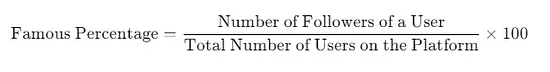

In [103]:
spark = SparkSession.builder.appName("FamousPercentage").getOrCreate()
famous_data = [
    (1, 2), (1, 3), (2, 4), (5, 1), (5, 3),
    (11, 7), (12, 8), (13, 5), (13, 10),
    (14, 12), (14, 3), (15, 14), (15, 13)
]

columns = ["user_id", "follower_id"]

df_famous = spark.createDataFrame(famous_data, columns)

In [104]:
number_of_users = df_famous.distinct().count()

In [108]:
df_famous_groupped = df_famous.groupBy("user_id")\
    .agg(F.round((F.count("follower_id").alias("followers") / number_of_users) * 100, 2).alias("Famous percentage")).orderBy("user_id")

In [109]:
df_famous_groupped.show()

+-------+-----------------+
|user_id|Famous percentage|
+-------+-----------------+
|      1|            15.38|
|      2|             7.69|
|      5|            15.38|
|     11|             7.69|
|     12|             7.69|
|     13|            15.38|
|     14|            15.38|
|     15|            15.38|
+-------+-----------------+



# Question 6
We are given a table of Uber rides that contains information about the mileage and the purpose of the business expense. 

Our task is to find the top 3 business purpose categories that generate the most miles driven by passengers using Uber for business transportation.

In [110]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType

spark = SparkSession.builder.appName("TopBusinessPurposes").getOrCreate()

data = [
    ('2016-01-01 21:11', '2016-01-01 21:17', 'Business', 'Fort Pierce', 'Fort Pierce', 5.1, 'Meal/Entertain'),
    ('2016-01-02 01:25', '2016-01-02 01:37', 'Business', 'Fort Pierce', 'Fort Pierce', 5, None),
    ('2016-01-02 20:25', '2016-01-02 20:38', 'Business', 'Fort Pierce', 'Fort Pierce', 4.8, 'Errand/Supplies'),
    ('2016-01-05 17:31', '2016-01-05 17:45', 'Business', 'Fort Pierce', 'Fort Pierce', 4.7, 'Meeting'),
    ('2016-01-06 14:42', '2016-01-06 15:49', 'Business', 'Fort Pierce', 'West Palm Beach', 63.7, 'Customer Visit'),
    ('2016-01-06 17:15', '2016-01-06 17:19', 'Business', 'West Palm Beach', 'West Palm Beach', 4.3, 'Meal/Entertain'),
    ('2016-01-06 17:30', '2016-01-06 17:35', 'Business', 'West Palm Beach', 'Palm Beach', 7.1, 'Meeting')
]

schema = StructType([
    StructField("start_date", StringType(), True),
    StructField("end_date", StringType(), True),
    StructField("category", StringType(), True),
    StructField("start", StringType(), True),
    StructField("stop", StringType(), True),
    StructField("miles", FloatType(), True),
    StructField("purpose", StringType(), True)
])

data_with_float_miles = [(start_date, end_date, category, start, stop, float(miles), purpose)
                         for (start_date, end_date, category, start, stop, miles, purpose) in data]

df = spark.createDataFrame(data_with_float_miles, schema)

25/03/04 16:25:46 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [111]:
df.show()

+----------------+----------------+--------+---------------+---------------+-----+---------------+
|      start_date|        end_date|category|          start|           stop|miles|        purpose|
+----------------+----------------+--------+---------------+---------------+-----+---------------+
|2016-01-01 21:11|2016-01-01 21:17|Business|    Fort Pierce|    Fort Pierce|  5.1| Meal/Entertain|
|2016-01-02 01:25|2016-01-02 01:37|Business|    Fort Pierce|    Fort Pierce|  5.0|           NULL|
|2016-01-02 20:25|2016-01-02 20:38|Business|    Fort Pierce|    Fort Pierce|  4.8|Errand/Supplies|
|2016-01-05 17:31|2016-01-05 17:45|Business|    Fort Pierce|    Fort Pierce|  4.7|        Meeting|
|2016-01-06 14:42|2016-01-06 15:49|Business|    Fort Pierce|West Palm Beach| 63.7| Customer Visit|
|2016-01-06 17:15|2016-01-06 17:19|Business|West Palm Beach|West Palm Beach|  4.3| Meal/Entertain|
|2016-01-06 17:30|2016-01-06 17:35|Business|West Palm Beach|     Palm Beach|  7.1|        Meeting|
+---------

In [113]:
groupped_df = df.filter(F.col("category") == "Business")\
    .groupBy("purpose").agg(F.sum("miles").alias("total_miles")).orderBy(F.desc("total_miles"))

In [115]:
groupped_df.show(3)

+--------------+------------------+
|       purpose|       total_miles|
+--------------+------------------+
|Customer Visit| 63.70000076293945|
|       Meeting|11.799999713897705|
|Meal/Entertain| 9.400000095367432|
+--------------+------------------+
only showing top 3 rows



# Question 7
Given data on nominees_informationand oscar_nominees.

We need to find the genre of the person with the most Oscar wins. 

In case of a tie (multiple people with the same number of wins), we need to return the person who comes first alphabetically by their name.

In [124]:
spark = SparkSession.builder.appName("OscarWins").getOrCreate()

nominee_data = [
    ('Jennifer Lawrence', 'P562566', 'Drama', '1990-08-15', 755),
    ('Jonah Hill', 'P418718', 'Comedy', '1983-12-20', 747),
    ('Anne Hathaway', 'P292630', 'Drama', '1982-11-12', 744),
    ('Jennifer Hudson', 'P454405', 'Drama', '1981-09-12', 742),
    ('Rinko Kikuchi', 'P475244', 'Drama', '1981-01-06', 739)
]

oscar_data = [
    (2008, 'actress in a leading role', 'Anne Hathaway', 'Rachel Getting Married', 0, 77),
    (2012, 'actress in a supporting role', 'Anne Hathaway', 'Mis_rables', 1, 78),
    (2006, 'actress in a supporting role', 'Jennifer Hudson', 'Dreamgirls', 1, 711),
    (2010, 'actress in a leading role', 'Jennifer Lawrence', 'Winters Bone', 1, 717),
    (2012, 'actress in a leading role', 'Jennifer Lawrence', 'Silver Linings Playbook', 1, 718),
    (2011, 'actor in a supporting role', 'Jonah Hill', 'Moneyball', 0, 799),
    (2006, 'actress in a supporting role', 'Rinko Kikuchi', 'Babel', 0, 1253)
]

columns_nominee = ["name", "amg_person_id", "top_genre", "birthday", "id"]

columns_oscar = ["year", "category", "nominee", "movie", "winner", "id"]

df_nominee = spark.createDataFrame(nominee_data, columns_nominee)
df_oscar = spark.createDataFrame(oscar_data, columns_oscar)

In [125]:
df_nominee.show()

+-----------------+-------------+---------+----------+---+
|             name|amg_person_id|top_genre|  birthday| id|
+-----------------+-------------+---------+----------+---+
|Jennifer Lawrence|      P562566|    Drama|1990-08-15|755|
|       Jonah Hill|      P418718|   Comedy|1983-12-20|747|
|    Anne Hathaway|      P292630|    Drama|1982-11-12|744|
|  Jennifer Hudson|      P454405|    Drama|1981-09-12|742|
|    Rinko Kikuchi|      P475244|    Drama|1981-01-06|739|
+-----------------+-------------+---------+----------+---+



In [126]:
df_oscar.show()

+----+--------------------+-----------------+--------------------+------+----+
|year|            category|          nominee|               movie|winner|  id|
+----+--------------------+-----------------+--------------------+------+----+
|2008|actress in a lead...|    Anne Hathaway|Rachel Getting Ma...|     0|  77|
|2012|actress in a supp...|    Anne Hathaway|          Mis_rables|     1|  78|
|2006|actress in a supp...|  Jennifer Hudson|          Dreamgirls|     1| 711|
|2010|actress in a lead...|Jennifer Lawrence|        Winters Bone|     1| 717|
|2012|actress in a lead...|Jennifer Lawrence|Silver Linings Pl...|     1| 718|
|2011|actor in a suppor...|       Jonah Hill|           Moneyball|     0| 799|
|2006|actress in a supp...|    Rinko Kikuchi|               Babel|     0|1253|
+----+--------------------+-----------------+--------------------+------+----+



In [127]:
df_oscar_groupped = df_oscar.filter(F.col("winner") == 1).groupby("nominee").agg(F.count("winner").alias("wins"))

In [128]:
df_oscar_groupped.show()

+-----------------+----+
|          nominee|wins|
+-----------------+----+
|    Anne Hathaway|   1|
|  Jennifer Hudson|   1|
|Jennifer Lawrence|   2|
+-----------------+----+



In [129]:
df_oscar_nominee = df_oscar_groupped.join(df_nominee, df_oscar_groupped.nominee == df_nominee.name, "inner")

In [135]:
df_oscar_nominee.orderBy(F.desc("wins"), F.asc("name")).select("name", "wins", "top_genre").show(1)

+-----------------+----+---------+
|             name|wins|top_genre|
+-----------------+----+---------+
|Jennifer Lawrence|   2|    Drama|
+-----------------+----+---------+
only showing top 1 row



# Question 8
Given employee swipe in swipe out data. For each employee find the total in time.

In [137]:
import datetime
from pyspark.sql.types import StructType, StructField, LongType, TimestampType, StringType

input_data = [
    (11114, datetime.datetime.strptime('08:30:00.00', "%H:%M:%S.%f"), "I"),
    (11114, datetime.datetime.strptime('10:30:00.00', "%H:%M:%S.%f"), 'O'),
    (11114, datetime.datetime.strptime('11:30:00.00', "%H:%M:%S.%f"), 'I'),
    (11114, datetime.datetime.strptime('15:30:00.00', "%H:%M:%S.%f"), 'O'),
    (11115, datetime.datetime.strptime('09:30:00.00', "%H:%M:%S.%f"), 'I'),
    (11115, datetime.datetime.strptime('17:30:00.00', "%H:%M:%S.%f"), 'O')
]

input_schema = StructType([
    StructField('emp_id', LongType(), True),
    StructField('punch_time', TimestampType(), True),
    StructField('flag', StringType(), True)
])

df = spark.createDataFrame(data=input_data, schema=input_schema)

In [138]:
df.show()

+------+-------------------+----+
|emp_id|         punch_time|flag|
+------+-------------------+----+
| 11114|1900-01-01 08:30:00|   I|
| 11114|1900-01-01 10:30:00|   O|
| 11114|1900-01-01 11:30:00|   I|
| 11114|1900-01-01 15:30:00|   O|
| 11115|1900-01-01 09:30:00|   I|
| 11115|1900-01-01 17:30:00|   O|
+------+-------------------+----+



In [139]:
window_spec = Window.partitionBy("emp_id").orderBy("punch_time")

In [147]:
df = df.withColumn("time_diff", (F.unix_timestamp("punch_time") - F.unix_timestamp(F.lag("punch_time").over(window_spec))) / 3600)

In [ ]:
df.show()

+------+-------------------+----+---------+
|emp_id|         punch_time|flag|time_diff|
+------+-------------------+----+---------+
| 11114|1900-01-01 08:30:00|   I|     NULL|
| 11114|1900-01-01 10:30:00|   O|      2.0|
| 11114|1900-01-01 11:30:00|   I|      1.0|
| 11114|1900-01-01 15:30:00|   O|      4.0|
| 11115|1900-01-01 09:30:00|   I|     NULL|
| 11115|1900-01-01 17:30:00|   O|      8.0|
+------+-------------------+----+---------+



In [149]:
df.filter(F.col("flag") == "O").groupBy("emp_id").agg(F.sum("time_diff").alias("total_hours")).show()

+------+-----------+
|emp_id|total_hours|
+------+-----------+
| 11114|        6.0|
| 11115|        8.0|
+------+-----------+



25/03/05 02:09:19 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 14399556 ms exceeds timeout 120000 ms
25/03/05 02:09:19 WARN SparkContext: Killing executors is not supported by current scheduler.
25/03/05 02:09:19 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint